In [ ]:
# default_exp g_models.vae

# VAE Model

> VAE model

In [ ]:
#hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [ ]:
# export

from mrl.imports import *
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.g_models.generative_base import *
from mrl.dataloaders import *

In [ ]:
# export

class VAE_Transition(nn.Module):
    def __init__(self, d_latent):
        super().__init__()

        self.d_latent = d_latent
        self.transition = nn.Linear(d_latent, d_latent*2)

    def forward(self, x, z_scale=None):
        if z_scale is None:
            z_scale = 1.
        mu, logvar = self.get_stats(x)
        z = z_scale*torch.randn(mu.shape).to(mu.device)
        z = mu + z*torch.exp(0.5*logvar)
        kl_loss = 0.5 * (logvar.exp() + mu.pow(2) - 1 - logvar).sum(1).mean()
        return z, kl_loss

    def get_stats(self, x):
        mu, logvar = torch.chunk(self.transition(x), 2, dim=-1)
        return mu, logvar

In [ ]:
# export

class VAE(GenerativeModel):
    def __init__(self, encoder, decoder, prior=None, bos_idx=0, transition=None,
                forward_rollout=False, p_force=0., force_decay=0.99):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        if transition is None:
            transition = VAE_Transition(encoder.d_latent)
            
        self.transition = transition
        
        if prior is None:
            prior = NormalPrior(torch.zeros((encoder.d_latent)), torch.zeros((encoder.d_latent)),
                                trainable=False)

        self.prior = prior
        
        self.bos_idx = bos_idx
        self.z_scale = 1.
        self.forward_rollout = forward_rollout
        self.p_force = p_force
        self.force_decay = force_decay
        
    def forward(self, decoder_input, encoder_input=None, hiddens=None):
        if encoder_input is None:
            encoder_input = decoder_input
            
        z = self.encoder(encoder_input)
        z, kl_loss = self.transition(z, self.z_scale)
#         output, hiddens, encoded = self.decoder(decoder_input, z, hiddens)
        output, hiddens, encoded = self.decoder_forward(decoder_input, z, hiddens)
        return output, kl_loss
    
    def decoder_forward(self, x, z, hiddens=None):
        if self.forward_rollout:
            current_device = next(self.parameters()).device
            sl = x.shape[1]
            bs = x.shape[0]
            
            start_idx = torch.tensor([self.bos_idx]*bs).long().unsqueeze(-1)
        
            idxs = to_device(start_idx, device=current_device)
            
            output = []
            encoded = []
            
            for i in range(sl):
                output_iter, hiddens, encoded_iter = self.decoder(idxs,z,hiddens)
                output.append(output_iter)
                encoded.append(encoded_iter)
                
                if np.random.random()<self.p_force:
                    idxs = x[:,i].unsqueeze(-1)
                    
                else:
                    with torch.no_grad():
                        idxs = F.softmax(output_iter,-1).argmax(-1)
                        
            output = torch.cat(output, 1)
            encoded = torch.cat(encoded, 1)
            self.p_force = self.p_force * self.force_decay
            
        else:
            output, hiddens, encoded = self.decoder(x, z, hiddens)
            
        return output, hiddens, encoded
    
    def unpack_x(self, x):
        if isinstance(x, (list, tuple)):
            decoder_input, encoder_input = x
        else:
            encoder_input = x
            decoder_input = x
        
        return decoder_input, encoder_input
        
    def x_to_latent(self, x):
        decoder_input, encoder_input = self.unpack_x(x)
        
        z = self.encoder(encoder_input)
        z,_ = self.transition(z, self.z_scale)
        return z
        
    def sample(self, bs, sl, z=None, temperature=1., multinomial=True, z_scale=1.):
        
        current_device = next(self.parameters()).device
        
        start_idx = torch.tensor([self.bos_idx]*bs).long().unsqueeze(-1)
        
        preds = idxs = to_device(start_idx, device=current_device)
        
        lps = []
        
        if z is None:
            if self.prior is not None:
                z = to_device(self.prior.rsample([bs]), device=current_device)
            else:
                prior = Normal(torch.zeros((self.encoder.d_latent)),
                               torch.ones((self.encoder.d_latent)))
                z = to_device(self.prior.rsample([bs]), device=current_device)
        else:
            bs = z.shape[0]
        
        hiddens = None
        
        for i in range(sl):
            x, hiddens, encoded = self.decoder(idxs, z, hiddens)
            x.div_(temperature)
            
            idxs, lp = x_to_preds(x, multinomial=multinomial)
            
            lps.append(lp)            
            preds = torch.cat([preds, idxs], -1)
            
        return preds[:, 1:], torch.cat(lps,-1)
        
    def sample_no_grad(self, bs, sl, z=None, temperature=1., multinomial=True):
        with torch.no_grad():
            return self.sample(bs, sl, z=z, temperature=temperature, multinomial=multinomial)
        
    def get_rl_tensors(self, x, y, temperature=1., latent=None):
        
        decoder_input, encoder_input = self.unpack_x(x)
            
        if latent is None:
            latent = self.encoder(encoder_input)
            latent,_ = self.transition(latent)
            
        output, hiddens, encoded = self.decoder(decoder_input, latent)
        
        output.div_(temperature)
        lps = F.log_softmax(output, -1)

        if self.prior.trainable:
            prior_lps = self.prior.log_prob(z)
            prior_lps = prior_lps.mean(-1).unsqueeze(-1).unsqueeze(-1)
            pass_through = torch.zeros(prior_lps.shape).float().to(prior_lps.device)
            pass_through = pass_through + prior_lps - prior_lps.detach() # add to gradient chain
            lps = lps + pass_through
            
        lps_gathered = gather_lps(lps, y)
        return output, lps, lps_gathered, encoded
    
    def set_prior_from_stats(self, mu, logvar, trainable=False):
        mu = mu.detach()
        logvar = logvar.detach()
        self.prior = NormalPrior(mu, logvar, trainable)
        
    def set_prior_from_latent(self, z, trainable=False):
        mu, logvar = self.transition.get_stats(z)
        self.set_prior_from_stats(mu, logvar, trainable)
        
    def set_prior_from_encoder(self, x, trainable=False):
        decoder_input, encoder_input = self.unpack_x(x)
        assert encoder_input.shape[0]==1, "Must set prior from a single input"
        z = self.encoder(encoder_input)
        z = z.squeeze(0)
        self.set_prior_from_latent(z, trainable)

In [ ]:
encoder = LSTM_Encoder(32, 64, 128, 2, 128)
decoder = Conditional_LSTM_Block(32, 64, 128, 64, 128, 2,
                                condition_hidden=True, condition_output=True)
vae = VAE(encoder, decoder)

ints = torch.randint(0, 31, (8, 10))
x = ints[:,:-1]
y = ints[:,1:]

_ = vae(x)

decoder = Conditional_LSTM_Block(32, 64, 128, 64, 128, 2,
                                condition_hidden=False, condition_output=True)
vae = VAE(encoder, decoder)

_ = vae(x)

decoder = Conditional_LSTM_Block(32, 64, 128, 64, 128, 2,
                                condition_hidden=True, condition_output=False)
vae = VAE(encoder, decoder)

_ = vae(x)

_ = vae.sample(8, 16)

z = vae.prior.sample([8])
_ = vae.sample(8, 16, z=z)

o,lp,lpg,e = vae.get_rl_tensors(x,y)

vae.set_prior_from_encoder(x[0].unsqueeze(0), trainable=True);

o,lp,lpg,e = vae.get_rl_tensors(x,y)
loss = lpg.mean()
assert vae.prior.loc.grad is None
loss.backward()
assert vae.prior.loc.grad is not None

latent = torch.randn((x.shape[0], 128))
o,lp,lpg,e = vae.get_rl_tensors(x,y,latent=latent)

In [ ]:
# export

class LSTM_VAE(VAE):
    def __init__(self, d_vocab, d_embedding, d_hidden, n_layers, d_latent,
                input_dropout=0., lstm_dropout=0., 
                condition_hidden=True, condition_output=True,
                prior=None, bos_idx=0, transition=None,
                forward_rollout=False, p_force=0., force_decay=0.99):
        
        encoder = LSTM_Encoder(
                                d_vocab,
                                d_embedding,
                                d_hidden,
                                n_layers,
                                d_latent,
                                input_dropout=input_dropout,
                                lstm_dropout=lstm_dropout
                            )
        
        decoder = Conditional_LSTM_Block(
                                d_vocab,
                                d_embedding,
                                d_hidden,
                                d_embedding,
                                d_latent,
                                n_layers,
                                input_dropout=input_dropout,
                                lstm_dropout=lstm_dropout,
                                bidir=False,
                                condition_hidden=condition_hidden,
                                condition_output=condition_output,
                            )
        
        
        super().__init__(encoder, decoder, prior, bos_idx, transition,
                        forward_rollout, p_force, force_decay)

In [ ]:
vae = LSTM_VAE(32, 64, 128, 2, 128, condition_hidden=True, condition_output=True)

ints = torch.randint(0, 31, (8, 10))
x = ints[:,:-1]
y = ints[:,1:]

_ = vae(x)

_ = vae.sample(8, 16)

z = vae.prior.sample([8])
_ = vae.sample(8, 16, z=z)

_ = vae.get_rl_tensors(x,y)

In [ ]:
# export

class Conv_VAE(VAE):
    def __init__(self, d_vocab, d_embedding, 
                 conv_filters, kernel_sizes, strides, conv_drops,
                 d_hidden, n_layers, d_latent, 
                 input_dropout=0., lstm_dropout=0.,
                 condition_hidden=True, condition_output=True,
                 prior=None, bos_idx=0, transition=None,
                 forward_rollout=False, p_force=0., force_decay=0.99):
        
        encoder = Conv_Encoder(
                                d_vocab,
                                d_embedding,
                                d_latent,
                                conv_filters,
                                kernel_sizes,
                                strides,
                                conv_drops,
                            )
        
        decoder = Conditional_LSTM_Block(
                                d_vocab,
                                d_embedding,
                                d_hidden,
                                d_embedding,
                                d_latent,
                                n_layers,
                                input_dropout=input_dropout,
                                lstm_dropout=lstm_dropout,
                                bidir=False,
                                condition_hidden=condition_hidden,
                                condition_output=condition_output,
                            )
        
        super().__init__(encoder, decoder, prior, bos_idx, transition,
                        forward_rollout, p_force, force_decay)

In [ ]:
vae = Conv_VAE(32, 64, [128, 256], [7,7], [2,2], [0.1,0.1], 128, 2, 128, 
               condition_hidden=False, condition_output=True)

ints = torch.randint(0, 31, (8, 10))
x = ints[:,:-1]
y = ints[:,1:]

_ = vae(y,x)

_ = vae.sample(8, 16)

z = vae.prior.sample([8])
_ = vae.sample(8, 16, z=z)

_ = vae.get_rl_tensors(x,y)

In [ ]:
# export
        
class MLP_VAE(VAE):
    def __init__(self, d_vocab, d_embedding, encoder_d_in, encoder_dims, encoder_drops,
                 d_hidden, n_layers, d_latent, 
                 input_dropout=0., lstm_dropout=0.,
                 condition_hidden=True, condition_output=True,
                 prior=None, bos_idx=0, transition=None,
                 forward_rollout=False, p_force=0., force_decay=0.99):
        
        
        encoder = MLP_Encoder(encoder_d_in, encoder_dims, d_latent, encoder_drops)
        
        decoder = Conditional_LSTM_Block(
                                d_vocab,
                                d_embedding,
                                d_hidden,
                                d_embedding,
                                d_latent,
                                n_layers,
                                input_dropout=input_dropout,
                                lstm_dropout=lstm_dropout,
                                bidir=False,
                                condition_hidden=condition_hidden,
                                condition_output=condition_output,
                            )
        
        super().__init__(encoder, decoder, prior, bos_idx, transition,
                        forward_rollout, p_force, force_decay)
    
    

In [ ]:
vae = MLP_VAE(32, 64, 128, [64, 32], [0.1, 0.1], 128, 2, 128, 
               condition_hidden=False, condition_output=True)

ints = torch.randint(0, 31, (8, 10))
x = ints[:,:-1]
y = ints[:,1:]

condition = torch.randn((8,128))


_ = vae(x, condition)

_ = vae.sample(8, 16)

z = vae.prior.sample([8])
_ = vae.sample(8, 16, z=z)

_ = vae.get_rl_tensors([x, condition],y)

In [ ]:
# export

class VAELoss():
    def __init__(self, weight=1.):
        self.ce = CrossEntropy()
        self.weight = weight
        
    def __call__(self, inputs, targs):
        output, kl_loss = inputs
        return self.ce(output, targs) + self.weight*kl_loss

In [ ]:
# export

def vae_seq2seq_collate(batch, pad_idx, batch_first=True):
    x,y = lm_collate(batch, pad_idx, batch_first)
    output = ((y,x),y)
    return output

In [ ]:
# export

class VAE_Seq2Seq_Dataset(Text_Dataset):
    '''
    VAE_Seq2Seq_Dataset - seq to seq dataset for VAEs
    
    Inputs:
    
        `sequences` - list[tuple], list of text tuples (source, target)
        
        `vocab` - Vocab, vocabuary for tokenization/numericaization
        
        `collate_function` - batch collate function. If None, defauts to `vae_seq2seq_collate`
    '''
    def __init__(self, sequences, vocab, collate_function=None):
        if collate_function is None:
            collate_function = partial(vae_seq2seq_collate, pad_idx=vocab.stoi['pad'])
            
        super().__init__(sequences, vocab, collate_function)

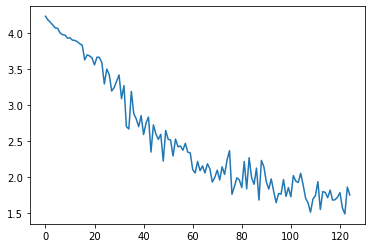

In [ ]:
# slow

# text reconstruction

from mrl.vocab import *
from mrl.dataloaders import *

df = pd.read_csv('files/smiles.csv')
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(df.smiles.values, vocab)
dl = ds.dataloader(16, num_workers=0)
loss = VAELoss()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
bidir = False
condition_hidden = True
condition_output = True
bos_idx = vocab.stoi['bos']

model = LSTM_VAE(
                d_vocab,
                d_embedding,
                d_hidden,
                n_layers,
                d_latent,
                input_dropout=0.0,
                lstm_dropout=0.0,
                condition_hidden=condition_hidden,
                condition_output=condition_output,
                prior=None,
                bos_idx=bos_idx,
                transition=None,
            )


to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

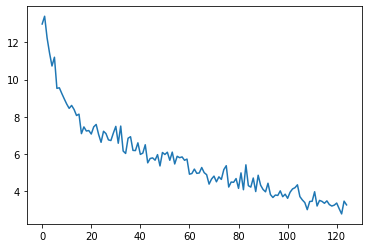

In [ ]:
# slow

# text reconstruction conv

from mrl.vocab import *
from mrl.dataloaders import *

df = pd.read_csv('files/smiles.csv')
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(df.smiles.values, vocab)
dl = ds.dataloader(16, num_workers=0)
loss = VAELoss()

d_vocab = len(vocab.itos)
d_embedding = 256
conv_filters = [128, 256, 512]
kernel_sizes = [7,7,7]
strides = [2,2,2]
conv_drops = [0.3, 0.3, 0.3]
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
bidir = False
condition_hidden = True
condition_output = True
bos_idx = vocab.stoi['bos']

model = Conv_VAE(
                d_vocab,
                d_embedding,
                conv_filters,
                kernel_sizes,
                strides,
                conv_drops,
                d_hidden,
                n_layers,
                d_latent,
                input_dropout=input_dropout,
                lstm_dropout=lstm_dropout,
                condition_hidden=condition_hidden,
                condition_output=condition_output,
                prior=None,
                bos_idx=bos_idx,
                transition=None,
            )


to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


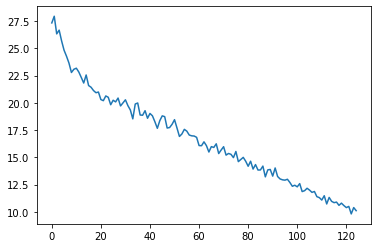

In [ ]:
# slow

# vector to text

from mrl.vocab import *
from mrl.dataloaders import *
from mrl.chem import ECFP6

df = pd.read_csv('files/smiles.csv')
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Vec_To_Text_Dataset(df.smiles.values, vocab, ECFP6)
dl = ds.dataloader(16, num_workers=0)
loss = VAELoss()

d_vocab = len(vocab.itos)
d_embedding = 256
encoder_d_in = 2048
encoder_dims = [1024, 512]
encoder_drops = [0.1, 0.1]
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
bidir = False
condition_hidden = True
condition_output = True
bos_idx = vocab.stoi['bos']


model = MLP_VAE(
            d_vocab,
            d_embedding,
            encoder_d_in,
            encoder_dims,
            encoder_drops,
            d_hidden,
            n_layers,
            d_latent,
            input_dropout=input_dropout,
            lstm_dropout=lstm_dropout,
            condition_hidden=condition_hidden,
            condition_output=condition_output,
            prior=None,
            bos_idx=bos_idx,
            transition=None,
        )

to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(*x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

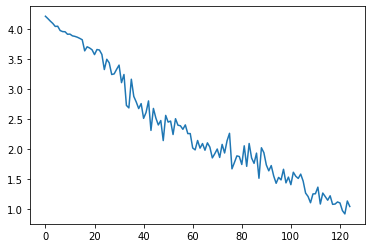

In [ ]:
# slow

# text to text

from mrl.vocab import *
from mrl.dataloaders import *
from rdkit.Chem.Scaffolds import MurckoScaffold
from mrl.chem import to_mol, to_smile


df = pd.read_csv('files/smiles.csv')
source_smiles = [to_smile(MurckoScaffold.GetScaffoldForMol(to_mol(i))) for i in df.smiles.values]
target_smiles = df.smiles.values
smiles = [(source_smiles[i], target_smiles[i]) for i in range(len(source_smiles))]

vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = VAE_Seq2Seq_Dataset(smiles, vocab)
dl = ds.dataloader(16, num_workers=0)
loss = VAELoss()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
bidir = False
condition_hidden = True
condition_output = True
bos_idx = vocab.stoi['bos']

model = LSTM_VAE(
                d_vocab,
                d_embedding,
                d_hidden,
                n_layers,
                d_latent,
                input_dropout=0.0,
                lstm_dropout=0.0,
                condition_hidden=condition_hidden,
                condition_output=condition_output,
                prior=None,
                bos_idx=bos_idx,
                transition=None,
            )


to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(*x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

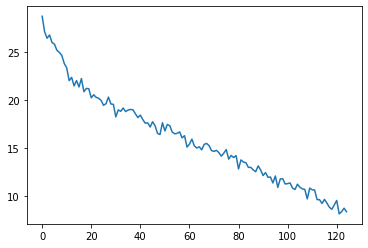

In [ ]:
# slow

# vec to text

from mrl.vocab import *
from mrl.dataloaders import *
from rdkit.Chem.Scaffolds import MurckoScaffold
from mrl.chem import to_mol, to_smile


df = pd.read_csv('files/smiles.csv')
source_smiles = [to_smile(MurckoScaffold.GetScaffoldForMol(to_mol(i))) for i in df.smiles.values]
target_smiles = df.smiles.values
smiles = [(source_smiles[i], target_smiles[i]) for i in range(len(source_smiles))]

vocab = CharacterVocab(SMILES_CHAR_VOCAB)


ds = Vec_To_Text_Dataset(smiles, vocab, ECFP6)
dl = ds.dataloader(16, num_workers=0)
loss = VAELoss()

d_vocab = len(vocab.itos)
d_embedding = 256
encoder_d_in = 2048
encoder_dims = [1024, 512]
encoder_drops = [0.1, 0.1]
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
bidir = False
condition_hidden = True
condition_output = True
bos_idx = vocab.stoi['bos']


model = MLP_VAE(
            d_vocab,
            d_embedding,
            encoder_d_in,
            encoder_dims,
            encoder_drops,
            d_hidden,
            n_layers,
            d_latent,
            input_dropout=input_dropout,
            lstm_dropout=lstm_dropout,
            condition_hidden=condition_hidden,
            condition_output=condition_output,
            prior=None,
            bos_idx=bos_idx,
            transition=None,
        )

to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(*x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

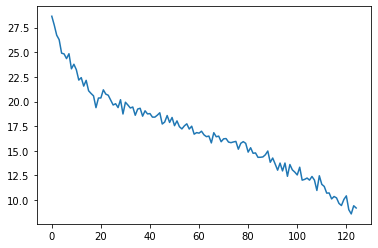

In [ ]:
# slow

# vec to text with rollout

from mrl.vocab import *
from mrl.dataloaders import *
from rdkit.Chem.Scaffolds import MurckoScaffold
from mrl.chem import to_mol, to_smile


df = pd.read_csv('files/smiles.csv')
source_smiles = [to_smile(MurckoScaffold.GetScaffoldForMol(to_mol(i))) for i in df.smiles.values]
target_smiles = df.smiles.values
smiles = [(source_smiles[i], target_smiles[i]) for i in range(len(source_smiles))]

vocab = CharacterVocab(SMILES_CHAR_VOCAB)


ds = Vec_To_Text_Dataset(smiles, vocab, ECFP6)
dl = ds.dataloader(16, num_workers=0)
loss = VAELoss()

d_vocab = len(vocab.itos)
d_embedding = 256
encoder_d_in = 2048
encoder_dims = [1024, 512]
encoder_drops = [0.1, 0.1]
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
bidir = False
condition_hidden = True
condition_output = True
bos_idx = vocab.stoi['bos']
forward_rollout=True
p_force=1.
force_decay=0.9


model = MLP_VAE(
            d_vocab,
            d_embedding,
            encoder_d_in,
            encoder_dims,
            encoder_drops,
            d_hidden,
            n_layers,
            d_latent,
            input_dropout=input_dropout,
            lstm_dropout=lstm_dropout,
            condition_hidden=condition_hidden,
            condition_output=condition_output,
            prior=None,
            bos_idx=bos_idx,
            transition=None,
            forward_rollout=forward_rollout,
            p_force=p_force,
            force_decay=force_decay
        )

to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(*x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

In [ ]:
# hide
from nbdev.export import notebook2script; notebook2script()